# Sparse fascicle models

As mentioned in the [DTI](DTI.ipynb) notebook, the tensor model has had large popularity and huge success in describing data measured in the white matter in many different situations. Nevertheless, already early on, in the work of Peter Basser and colleagues, and continuing with the work of Larry Frank (Frank, 2001, 2002), and others, there was an increasing understanding that though DTI may be a good *phenomenological* model of the diffusion data, it is not always a good description of the structure of the tissue. Thus, not necessarily a good *mechanistic* model of the physical causes of the signal. In particular, the principal diffusion direction (PDD) was initially thought to be a good description of the orientation of the nerve fiber fascicles within the voxel. However, in locations in which there is more than one fascicle, the PDD is oriented towards the average of these, rather than towards any of them in particular. Thus, the parameters of the model may be misleading, if one does not take care in interpreting them. 

In [1]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

import nibabel as nib

import dipy.core.gradients as grad
import dipy.sims.voxel as sims
import dipy.reconst.dti as dti
import dipy.reconst.sfm as sfm
import dipy.reconst.peaks as peaks

In [2]:
gtab = grad.gradient_table(op.join('data', 'SUB1_b2000_1.bvals'), op.join('data', 'SUB1_b2000_1.bvecs'))

Consider for example the following simulation of a signal from a simulated voxel with two different fascicles, occupying each an equal amount of partial volume of the voxel and oriented at an angle of 90 degrees from each other:

In [3]:
SNR = 100
S0 = 100
mevals = np.array(([0.0015, 0.0005, 0.0005],
                   [0.0015, 0.0005, 0.0005]))
angles = [(0, 0), (90, 0)]
sig, sticks = sims.multi_tensor(gtab, mevals, S0, angles=angles,
                                fractions=[50, 50], snr=SNR)

In this case, the true fascicle directions are: 

In [4]:
sticks

array([[  0.00000000e+00,   0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+00,   0.00000000e+00,   6.12323400e-17]])

In [5]:
dti_model = dti.TensorModel(gtab)
dti_fit = dti_model.fit(sig)

The principal diffusion direction of the model points in neither of these directions:

In [6]:
dti_fit.evecs[0]

array([-0.96634924,  0.25721007,  0.00348319])

Even though the model provides an excellent fit to the data

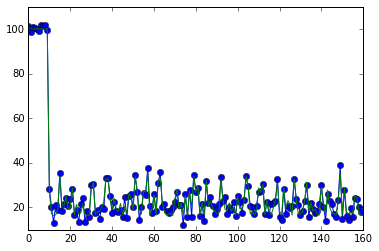

In [7]:
plt.plot(sig, 'o-')
plt.plot(dti_fit.predict(gtab, S0=100))

As a response to this challenge, several groups (Behrens et al. 2007, Tournier et al. 2007, Dell'Acqua et al. 2007) have proposed models and algorithms that describe the diffusion signal as a combination of signals due to different populations of fibers within the voxels. Since these models all restrict the number of fascicles in each voxel, we collectively refer to the as **Sparse Fascicle Models**. 

One way of formally describing these models is:

$y = X\beta$

Where $y$ is the signal and $\beta$ are weights on different points in the sphere. The columns of the design matrix, $X$ are the signals in each point in the measurement that would be predicted if there was a fascicle oriented in the direction of that column. Typically, this will be a prolate tensor with axial diffusivity 3-5 times higher than its radial diffusivity. The exact numbers can also be estimated from examining parts of the brain in which there is known to be only one fascicle (e.g. in corpus callosum).

We have developed an algorithm that fits this model applying sparsity constraints on the fiber ODF ($\beta$) through the the Elastic Net algorihtm (Zou and Hastie, 2005)

Elastic Net optimizes the following cost function:


$\sum_{i=1}^{n}{(y_i - \hat{y}_i)^2} + \alpha (\lambda \sum_{j=1}^{m}{w_j} +
(1-\lambda) \sum_{j=1}^{m}{w^2_j}$

where $\hat{y}$ is the signal predicted for a particular setting of $\beta$, such that the left part of this expression is the squared loss function; $alpha$ is a parameter that sets the balance between the squared loss on the data, and the regularization constraints. The regularization parameter $\lambda$ sets the `l1_ratio`, which controls the balance between L1-sparsity (low sum of weights), and low L2-sparsity (low sum-of-squares of the weights).

Below, we demonstrate the use of this algorithm to fit these data.

For the simulated fasicle directions fitting such a model provides not only a good fit to the data, but also approximately correct fascicle directions

In [8]:
sf_model = sfm.SparseFascicleModel(gtab)
sf_fit = sf_model.fit(sig)

Peak directions are derived from the orientation distribution function (ODF) of the model.

In [9]:
peak_dirs, _, _ = peaks.peak_directions(sf_fit.odf(sf_model.sphere), sf_model.sphere)

In [10]:
peak_dirs

array([[ 0.        ,  0.        ,  1.        ],
       [ 0.99399356, -0.10824931, -0.01608979]])

Let's consider a voxel in the actual data, in which the DTI model does not fit the data very well:

In [11]:
vox_idx = (53, 43, 47)
data1 = nib.load(op.join('data', 'SUB1_b2000_1.nii.gz')).get_data()[vox_idx]
data2 = nib.load(op.join('data', 'SUB1_b2000_2.nii.gz')).get_data()[vox_idx]

In [12]:
dti_fit = dti_model.fit(data1)
dti_predict = dti_fit.predict(gtab, S0=np.mean(data1[gtab.b0s_mask]))

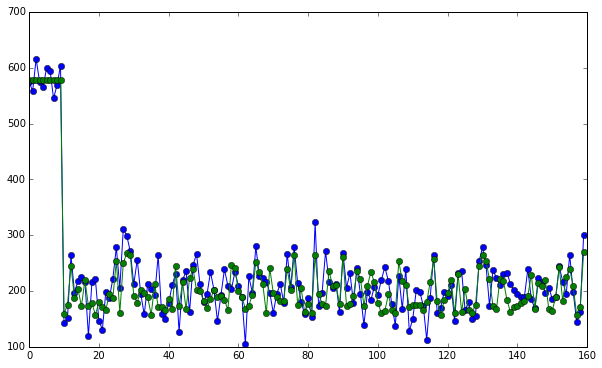

In [13]:
fig, ax = plt.subplots(1)
ax.plot(data2,'o-')
ax.plot(dti_predict,'o-')
fig.set_size_inches([10,6])

As before the DTI model can only represent a single principal diffusion direction:

In [14]:
dti_fit.evecs[0]

array([ 0.22675592,  0.22393016,  0.94785919])

while the SFM can find two distinct peaks in the ODF, or two different fascicle directions in this voxel

In [15]:
sf_fit = sf_model.fit(data1)
sf_predict = sf_fit.predict(gtab, S0=np.mean(data1[gtab.b0s_mask]))
peak_dirs, _, _ = peaks.peak_directions(sf_fit.odf(sf_model.sphere), sf_model.sphere)
print(peak_dirs)

[[-0.24476488 -0.40300661  0.8818593 ]
 [-0.10571651  0.97879494  0.17545508]]


This also results in a more accurate fit of the model to the data, and a fit that is substantially more accurate than test-retest reliability

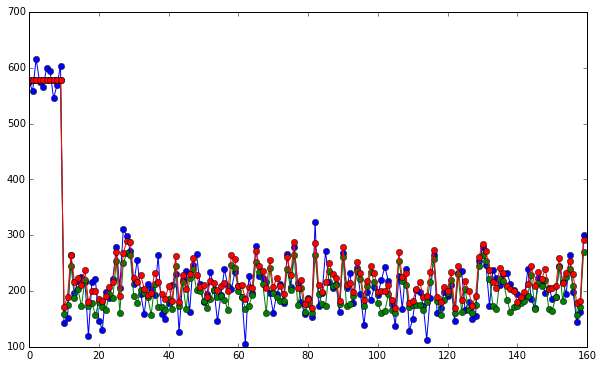

In [16]:
fig, ax = plt.subplots(1)
ax.plot(data2,'o-')
ax.plot(dti_predict,'o-')
ax.plot(sf_predict,'o-')
fig.set_size_inches([10,6])

(array([ 48.,  27.,  25.,  15.,  18.,  13.,   2.,   6.,   3.,   3.]),
 array([  0. ,   9.4,  18.8,  28.2,  37.6,  47. ,  56.4,  65.8,  75.2,
         84.6,  94. ]),
 <a list of 1 Patch objects>)

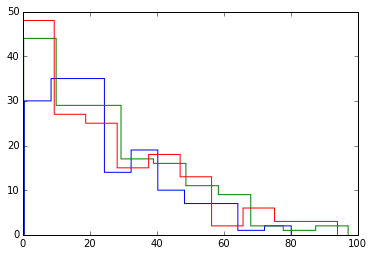

In [17]:
plt.hist(np.abs(sf_predict - data2), histtype='step')
plt.hist(np.abs(dti_predict - data2), histtype='step')
plt.hist(np.abs(data1 - data2), histtype='step')

In [18]:
rmse_retest = np.sqrt(np.mean((data1 - data2)**2))
rmse_dti = np.sqrt(np.mean((dti_predict - data2)**2))
rmse_sfm = np.sqrt(np.mean((sf_predict - data2)**2))
print("Test-retest RMSE: %2.2f"%rmse_retest)
print("DTI RMSE: %2.2f"%rmse_dti)
print("SFM RMSE: %2.2f"%rmse_sfm)

Test-retest RMSE: 33.86
DTI RMSE: 33.52
SFM RMSE: 29.53
